### Import Library

In [1]:
# Base Library
import pandas as pd
import numpy as np

# Library untuk Visualisasi Data
import seaborn as sns
import matplotlib.pyplot as plt

# Library untuk Data Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Library untuk Modeling dengan XGBoost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna

# Library untuk Evaluasi Model
from sklearn.metrics import mean_absolute_percentage_error, r2_score, root_mean_squared_error, make_scorer

### Business Understanding
---

1.	Algoritma machine learning apa yang dapat digunakan untuk memprediksi harga rumah di Kabupaten Tangerang?
2.	Bagaimana cara mengukur keakuratan dari model prediksi harga rumah di Kabupaten Tangerang?


### Data Understanding

In [2]:
# Baca Data
df = pd.read_csv("../Dataset/hasil_scraping_rumah123.csv", engine='pyarrow', sep=';')
df = df.drop(columns=['URL', 'IMB', 'Lainnya', 'Garasi'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Harga                 4991 non-null   object
 1   Lokasi                4991 non-null   object
 2   Kamar Tidur           4991 non-null   int64 
 3   Kamar Mandi           4991 non-null   int64 
 4   Luas Tanah            4991 non-null   object
 5   Luas Bangunan         4991 non-null   object
 6   Sertifikat            4991 non-null   object
 7   Daya Listrik          4991 non-null   object
 8   Jumlah Lantai         4991 non-null   int64 
 9   Kondisi Properti      4991 non-null   object
 10  Carport               4991 non-null   int64 
 11  Kamar Tidur Pembantu  4991 non-null   int64 
 12  Kamar Mandi Pembantu  4991 non-null   int64 
dtypes: int64(6), object(7)
memory usage: 507.0+ KB


In [3]:
# Lihat 5 baris data pertama
df.head()

,Harga,Lokasi,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
0,Rp 1 Miliar,"BSD, Tangerang",4,2,114 m²,147 m²,SHM,1300 Watt,2,Bagus,1,0,0
1,Rp 1 Miliar,"Tangerang, Tangerang",2,1,126 m²,60 m²,SHM,2200 Watt,1,Bagus,1,0,0
2,Rp 1 Miliar,"BSD City, Tangerang",3,2,84 m²,81 m²,HGB,1300 Watt,2,Bagus,1,0,0
3,Rp 1 Miliar,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0
4,Rp 1 Miliar,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0


#### Exploratory Data Analysis

In [4]:
# Lihat statistik dari dataset
df.describe()

,Kamar Tidur,Kamar Mandi,Jumlah Lantai,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
count,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000
mean,3.407734,2.783811,1.902424,1.393308,0.598077,0.520537
std,1.400634,1.501217,0.565806,0.702549,0.620579,0.576362
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000
50%,3.000000,3.000000,2.000000,1.000000,1.000000,0.000000
75%,4.000000,3.000000,2.000000,2.000000,1.000000,1.000000
max,34.000000,34.000000,4.000000,10.000000,5.000000,15.000000


C:\Users\dkpc2\AppData\Local\Temp\ipykernel_3260\238219180.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dkpc2\AppData\Local\Temp\ipykernel_3260\238219180.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dkpc2\AppData\Local\Temp\ipykernel_3260\238219180.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\dkpc2\AppData\Local\Temp\ipykernel_3260\238219180.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


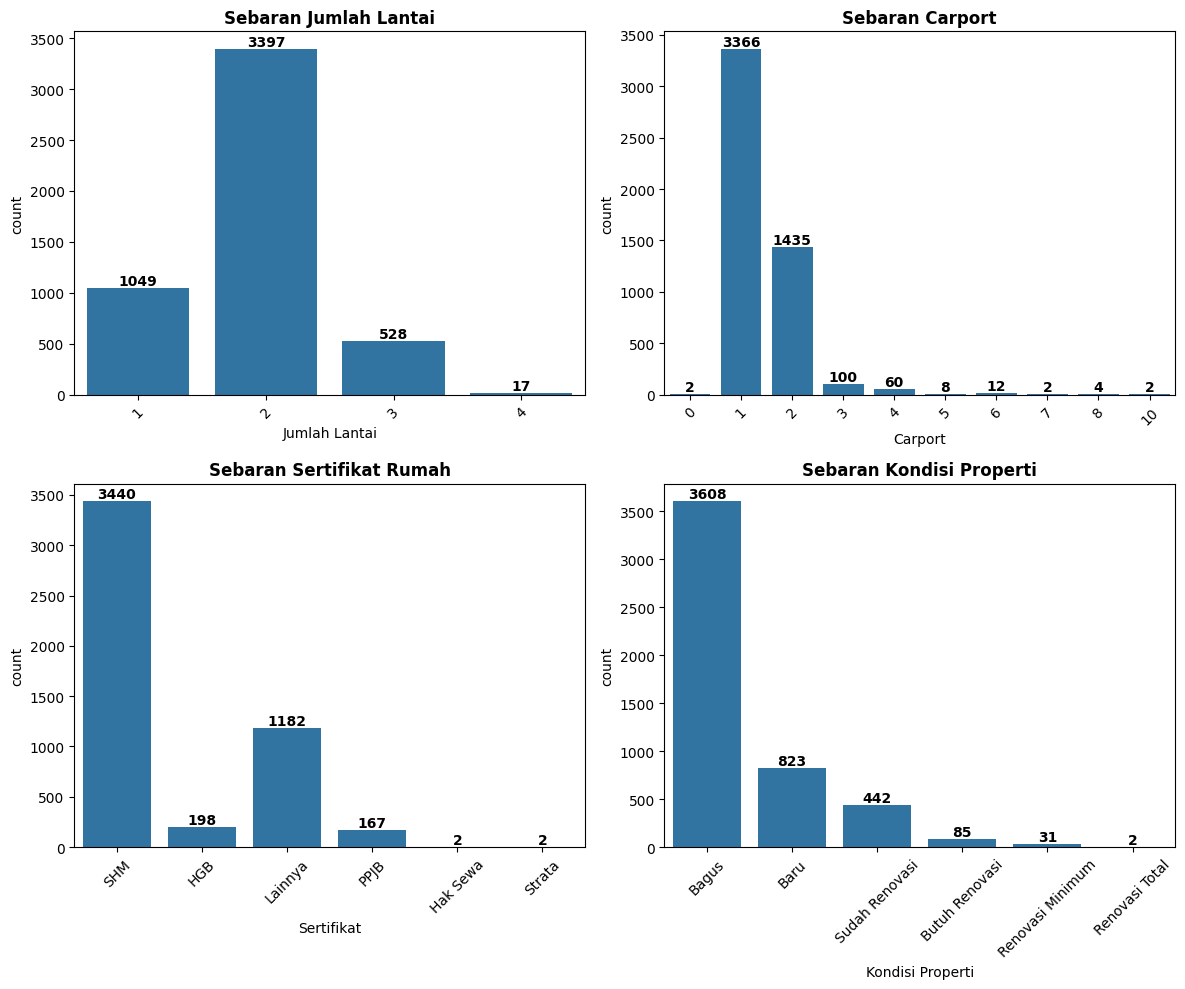

In [5]:
# Visualisasi beberapa kolom
# Membuat figure dengan 2 baris, 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List kolom dan judul
columns = ['Jumlah Lantai', 'Carport', 'Sertifikat', 'Kondisi Properti']
titles = ['Sebaran Jumlah Lantai', 'Sebaran Carport', 'Sebaran Sertifikat Rumah', 'Sebaran Kondisi Properti']

# Loop untuk membuat countplot dan menambahkan data label
for i, ax in enumerate(axes.flat):
    sns.countplot(x=df[columns[i]], ax=ax)
    ax.set_title(titles[i], weight='bold')

    # Menambahkan label di atas batang
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
        
    # Rotasi label sumbu x sebesar 45 derajat
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Menyesuaikan layout agar tidak saling menumpuk
plt.tight_layout()
plt.show()

### Preparation
Data Pre-processing:
1. Konversi tipe data
2. Feature Engineering
3. Filter Data
4. Outliers Handling
5. Enconding
6. Feature Selection
7. Data Splitting


#### Konversi Tipe Data

In [6]:
# Fungsi untuk mengkonversi harga dengan koma sebagai desimal
def convert_price(price):
    # Hapus 'Rp' dan spasi
    price = price.replace('Rp', '').strip()
    
    # Pisahkan angka dan satuan
    if 'Juta' in price:
        value = price.replace(' Juta', '').replace(',', '.')  # Ubah koma jadi titik
        multiplier = 1e6  # 1 Juta = 1.000.000
    elif 'Miliar' in price:
        value = price.replace(' Miliar', '').replace(',', '.')  # Ubah koma jadi titik
        multiplier = 1e9  # 1 Miliar = 1.000.000.000
    else:
        return None  # Jika format tidak sesuai
    
    # Konversi ke float dengan titik desimal, lalu ke integer
    value = float(value)  
    return int(value * multiplier)

# Menkonversi kolom 'Harga'
df['Harga'] = df['Harga'].apply(convert_price)

# Lihat 5 baris pertama setelah kolom 'Harga' dikonversi
df.head()

,Harga,Lokasi,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,Kamar Tidur Pembantu,Kamar Mandi Pembantu
0,1000000000,"BSD, Tangerang",4,2,114 m²,147 m²,SHM,1300 Watt,2,Bagus,1,0,0
1,1000000000,"Tangerang, Tangerang",2,1,126 m²,60 m²,SHM,2200 Watt,1,Bagus,1,0,0
2,1000000000,"BSD City, Tangerang",3,2,84 m²,81 m²,HGB,1300 Watt,2,Bagus,1,0,0
3,1000000000,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0
4,1000000000,"BSD, Tangerang",3,2,103 m²,66 m²,SHM,1300 Watt,1,Bagus,1,0,0


In [7]:
# # Cek lokasi
# # Cek apakah kolom "Lokasi" ada di dataset
# if "Lokasi" in df.columns:
#     # Hitung jumlah kemunculan tiap lokasi
#     lokasi_counts = df["Lokasi"].value_counts()
    
#     # Simpan hasilnya ke file teks
#     file_path = "lokasi_counts.txt"
#     lokasi_counts.to_csv(file_path, sep="\t", header=True)

#     print(f"Hasil disimpan di: {file_path}")
# else:
#     print("Kolom 'Lokasi' tidak ditemukan dalam dataset.")

In [8]:
# Merapikan data
# Hapus baris dengan nilai 'Lainnya' atau 'Lainnya Watt'
df = df[~df['Daya Listrik'].isin(['Lainnya', 'Lainnya Watt'])]

# Pastikan semua kolom bertipe string sebelum menggunakan .str.replace(), lalu convert ke int
df['Daya Listrik'] = df['Daya Listrik'].astype(str).str.replace(' Watt', '', regex=False).astype('Int64')
df['Luas Tanah'] = df['Luas Tanah'].astype(str).str.replace(' m²', '', regex=False).astype('Int64')
df['Luas Bangunan'] = df['Luas Bangunan'].astype(str).str.replace(' m²', '', regex=False).astype('Int64')

# Konversi kolom angka langsung ke integer
df['Kamar Tidur'] = df['Kamar Tidur'].astype('Int64')
df['Kamar Mandi'] = df['Kamar Mandi'].astype('Int64')
df['Jumlah Lantai'] = df['Jumlah Lantai'].astype('Int64')
df['Carport'] = df['Carport'].astype('Int64')
df['Kamar Tidur Pembantu'] = df['Kamar Tidur Pembantu'].astype('Int64')
df['Kamar Mandi Pembantu'] = df['Kamar Mandi Pembantu'].astype('Int64')
df['Kondisi Properti'] = df['Kondisi Properti'].str.replace('Sudah Renovasi', 'Bagus')
df['Kondisi Properti'] = df['Kondisi Properti'].str.replace('Renovasi Total', 'Butuh Renovasi')
df['Kondisi Properti'] = df['Kondisi Properti'].str.replace('Renovasi Minimum', 'Butuh Renovasi')

#### Feature Engineering

In [9]:
# Mapping lokasi
# Daftar kecamatan di Kabupaten Tangerang
desa_kabupaten = {
    "BSD Eminent": "Pagedangan",
    "BSD Green Wich": "Pagedangan",
    "BSD Avani": "Pagedangan",
    "BSD Vanya Park": "Pagedangan",
    "BSD Foresta": "Pagedangan",
    "BSD The Green": "Pagedangan",
    "BSD Kencana Loka": "Pagedangan",
    "BSD Taman Giri Loka": "Pagedangan",
    "BSD Telaga Golf": "Pagedangan",
    "BSD Neo Catalonia": "Pagedangan",
    "BSD Provance Parkland": "Pagedangan",
    "BSD Alegria": "Pagedangan",
    "Cikupa": "Cikupa",
    "Cikupa Citra Raya": "Cikupa",
    "Cisauk" : "Cisauk",
    "Suvarna Sutera": "Cikupa",
    "Panongan": "Panongan",
    "Curug": "Curug",
    "Legok": "Legok",
    "Pasar Kemis": "Pasar Kemis",
    "Sepatan": "Sepatan",
    "Bitung": "Curug",
    "Tigaraksa": "Tigaraksa",
    "Balaraja": "Balaraja",
    "Jayanti": "Jayanti",
    "Kosambi": "Kosambi",
    "Teluk Naga": "Teluk Naga",
    "Mauk": "Mauk",
    "Kresek": "Kresek",
    "Solear": "Solear",
    "Sindang Jaya": "Sindang Jaya",
    "Rajeg": "Rajeg",
    "Kadu": "Kadu",
    "Jatake": "Jatiuwung",
    "Bojong Nangka": "Kelapa Dua",
    "Suradita": "Cisauk",
    "Cukang Galih": "Curug",
    "Gading Serpong": "Kelapa Dua",
    "Gading Serpong Pondok Hijau Golf": "Kelapa Dua",
    "Gading Serpong The Spring": "Kelapa Dua",
    "Gading Serpong Scientia Garden": "Kelapa Dua",
    "Gading Serpong Samara Village": "Kelapa Dua",
    "Gading Serpong IL Lago": "Kelapa Dua",
    "Gading Serpong Elista Village": "Kelapa Dua",
    "Gading Serpong Serenade Lake": "Kelapa Dua",
    "Gading Serpong Cluster Bohemia": "Kelapa Dua",
    "Gading Serpong Omaha Village": "Kelapa Dua",
    "Gading Serpong La Bella Village": "Kelapa Dua",
    "Gading Serpong Virginia Village": "Kelapa Dua",
    "Gading Serpong Cluster Oleaster": "Kelapa Dua",
    "Gading Serpong Cluster Michelia": "Kelapa Dua",
    "Gading Serpong Karelia Village": "Kelapa Dua",
    "Gading Serpong Andalucia": "Kelapa Dua",
    "Gading Serpong Cluster IL Rosa": "Kelapa Dua",
    "Pasar Kemis" : "Pasar Kemis", 
}

# Fungsi untuk mengekstrak kecamatan dari lokasi
def extract_kecamatan(lokasi):
    for key in desa_kabupaten.keys():
        if key in lokasi:
            return desa_kabupaten[key]
    return None  # Jika tidak ditemukan

# Filter hanya rumah di Kabupaten Tangerang
df["Kecamatan"] = df["Lokasi"].apply(extract_kecamatan) # Extract nama kecamatan
df_kabupaten = df.dropna(subset=["Kecamatan"])  # Drop data rumah yang lokasinya bukan di Kabupaten Tangerang
df_kabupaten = df_kabupaten.drop(columns=['Lokasi']) # Drop kolom yang tidak digunakan

# Lihat informasi dataset setelah mapping dan filter data
df_kabupaten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1810 entries, 6 to 4990
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Harga                 1810 non-null   int64 
 1   Kamar Tidur           1810 non-null   Int64 
 2   Kamar Mandi           1810 non-null   Int64 
 3   Luas Tanah            1810 non-null   Int64 
 4   Luas Bangunan         1810 non-null   Int64 
 5   Sertifikat            1810 non-null   object
 6   Daya Listrik          1810 non-null   Int64 
 7   Jumlah Lantai         1810 non-null   Int64 
 8   Kondisi Properti      1810 non-null   object
 9   Carport               1810 non-null   Int64 
 10  Kamar Tidur Pembantu  1810 non-null   Int64 
 11  Kamar Mandi Pembantu  1810 non-null   Int64 
 12  Kecamatan             1810 non-null   object
dtypes: Int64(9), int64(1), object(3)
memory usage: 213.9+ KB


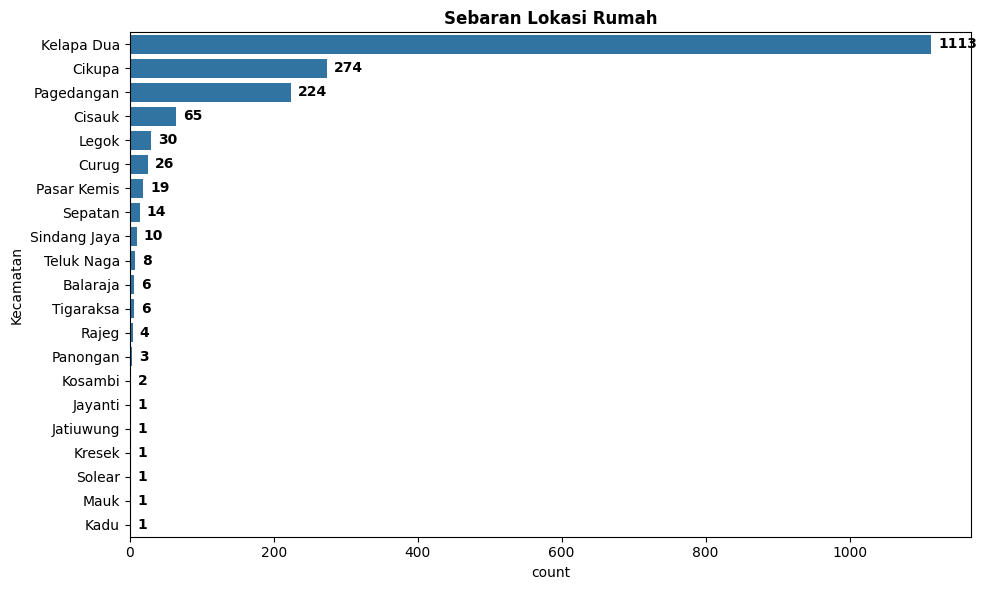

In [10]:
# Lihat sebaran kecamatan
# Membuat figure
plt.figure(figsize=(10, 6))

# Membuat countplot dengan urutan berdasarkan jumlah data
ax = sns.countplot(y=df_kabupaten['Kecamatan'], order=df_kabupaten['Kecamatan'].value_counts().index)

# Menambahkan judul
plt.title("Sebaran Lokasi Rumah", weight='bold')

# Menambahkan label pada setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}',  # Nilai jumlah properti
                (p.get_width(), p.get_y() + p.get_height() / 2),  # Posisi teks
                ha='left', va='center', fontsize=10, fontweight='bold', xytext=(5, 0), textcoords='offset points')

# Menyesuaikan layout agar tidak saling menumpuk
plt.tight_layout()
plt.show()

#### Filter Data

In [11]:
# Filter data yang diperlukan
df_kabupaten = df_kabupaten[(df_kabupaten['Carport'] != 0) & (df_kabupaten['Carport'] <= 4)]
df_kabupaten = df_kabupaten[(df_kabupaten['Jumlah Lantai'] != 0) & (df_kabupaten['Jumlah Lantai'] != 4)]
df_kabupaten = df_kabupaten[(df_kabupaten['Sertifikat'] != "Strata") & (df_kabupaten['Sertifikat'] != 'Hak Sewa')]

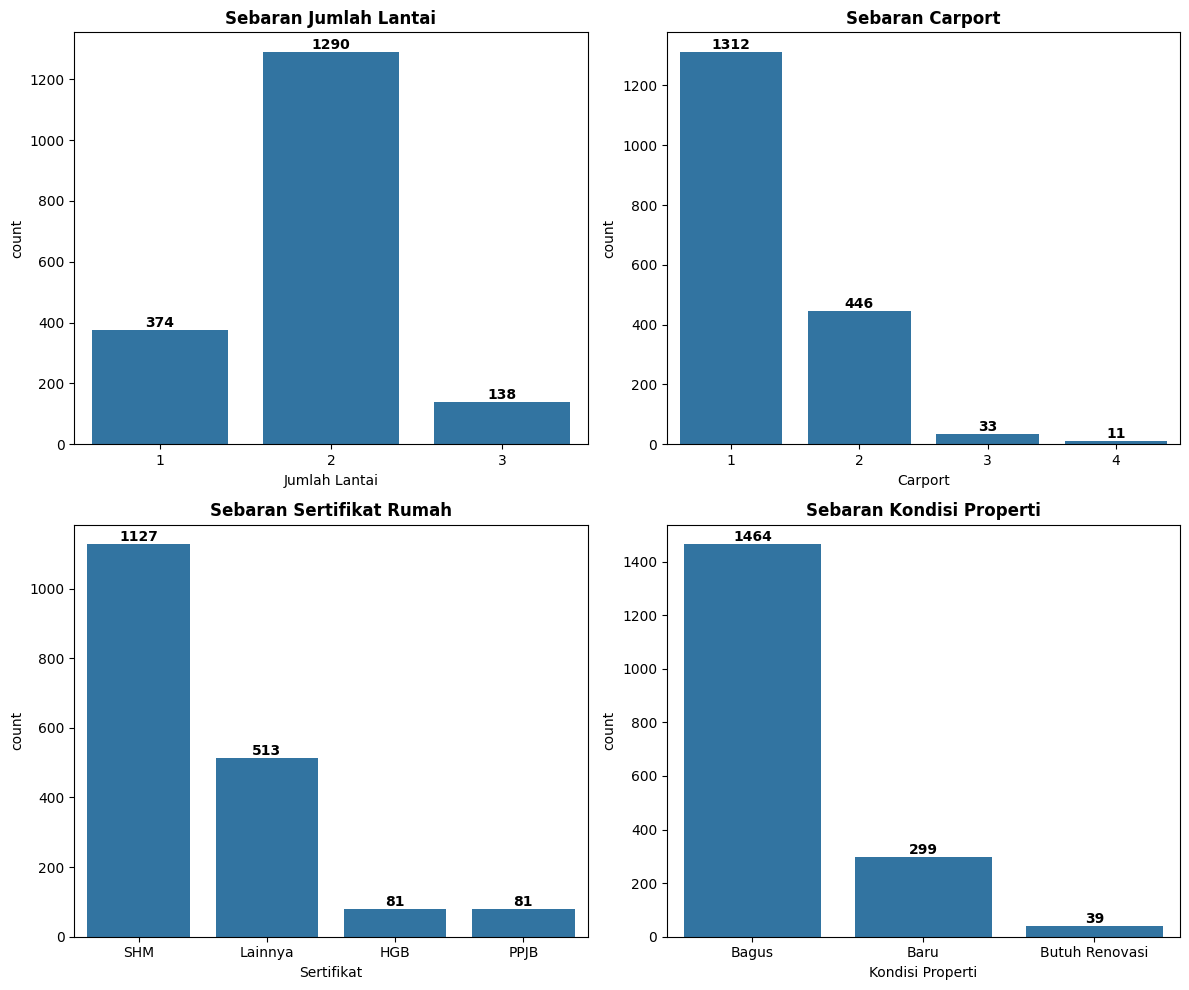

In [12]:
# Visualisasi beberapa kolom
# Membuat figure dengan 2 baris, 2 kolom
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List kolom dan judul
columns = ['Jumlah Lantai', 'Carport', 'Sertifikat', 'Kondisi Properti']
titles = ['Sebaran Jumlah Lantai', 'Sebaran Carport', 'Sebaran Sertifikat Rumah', 'Sebaran Kondisi Properti']

# Loop untuk membuat countplot dan menambahkan data label
for i, ax in enumerate(axes.flat):
    sns.countplot(x=df_kabupaten[columns[i]], ax=ax)
    ax.set_title(titles[i], weight='bold')

    # Menambahkan label di atas batang
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Menyesuaikan layout agar tidak saling menumpuk
plt.tight_layout()
plt.show()

#### Outliers Handling

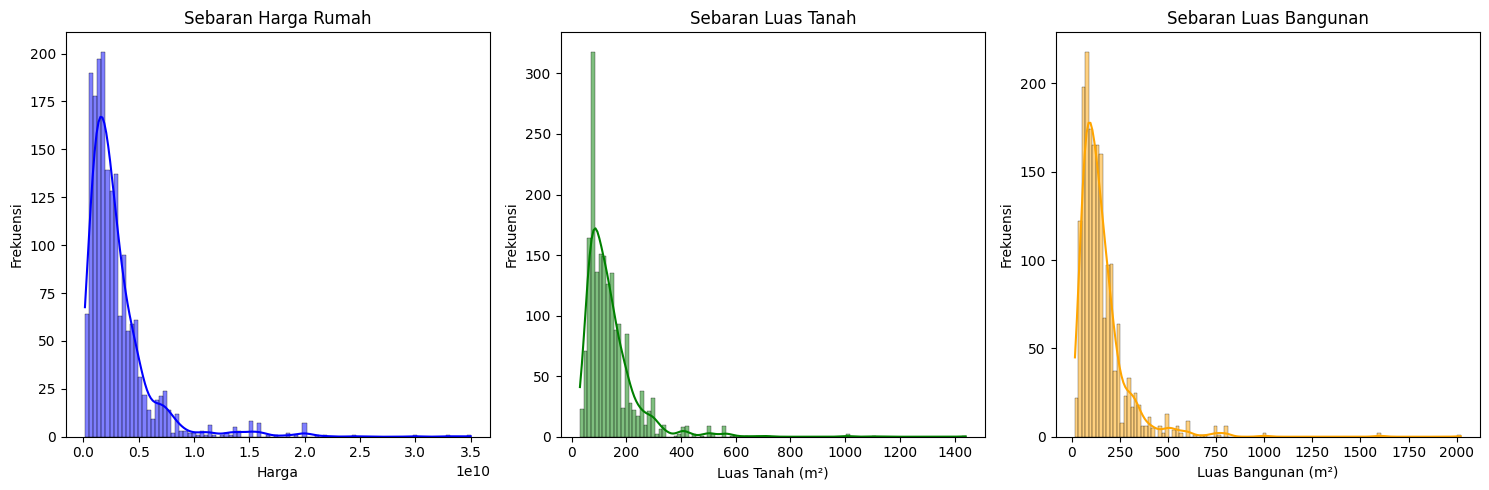

In [13]:
# Mengatur ukuran plot
plt.figure(figsize=(15, 5))

# Plot untuk harga
plt.subplot(1, 3, 1)  # 1 baris, 3 kolom, subplot ke-1
sns.histplot(df_kabupaten['Harga'], kde=True, color='blue')
plt.title('Sebaran Harga Rumah')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')

# Plot untuk luas tanah
plt.subplot(1, 3, 2)  # 1 baris, 3 kolom, subplot ke-2
sns.histplot(df_kabupaten['Luas Tanah'], kde=True, color='green')
plt.title('Sebaran Luas Tanah')
plt.xlabel('Luas Tanah (m²)')
plt.ylabel('Frekuensi')

# Plot untuk luas bangunan
plt.subplot(1, 3, 3)  # 1 baris, 3 kolom, subplot ke-3
sns.histplot(df_kabupaten['Luas Bangunan'], kde=True, color='orange')
plt.title('Sebaran Luas Bangunan')
plt.xlabel('Luas Bangunan (m²)')
plt.ylabel('Frekuensi')

# Menampilkan plot
plt.tight_layout()
plt.show()

In [14]:
# Lihat skewness
print("Skewness distribusi kolom Harga: ", np.round(df_kabupaten['Harga'].skew(), 2))
print("Skewness distribusi kolom Luas Tanah: ", np.round(df_kabupaten['Luas Tanah'].skew(), 2))
print("Skewness distribusi kolom Luas Bangunan: ", np.round(df_kabupaten['Luas Bangunan'].skew(), 2))

Skewness distribusi kolom Harga:  3.83
Skewness distribusi kolom Luas Tanah:  4.06
Skewness distribusi kolom Luas Bangunan:  4.62


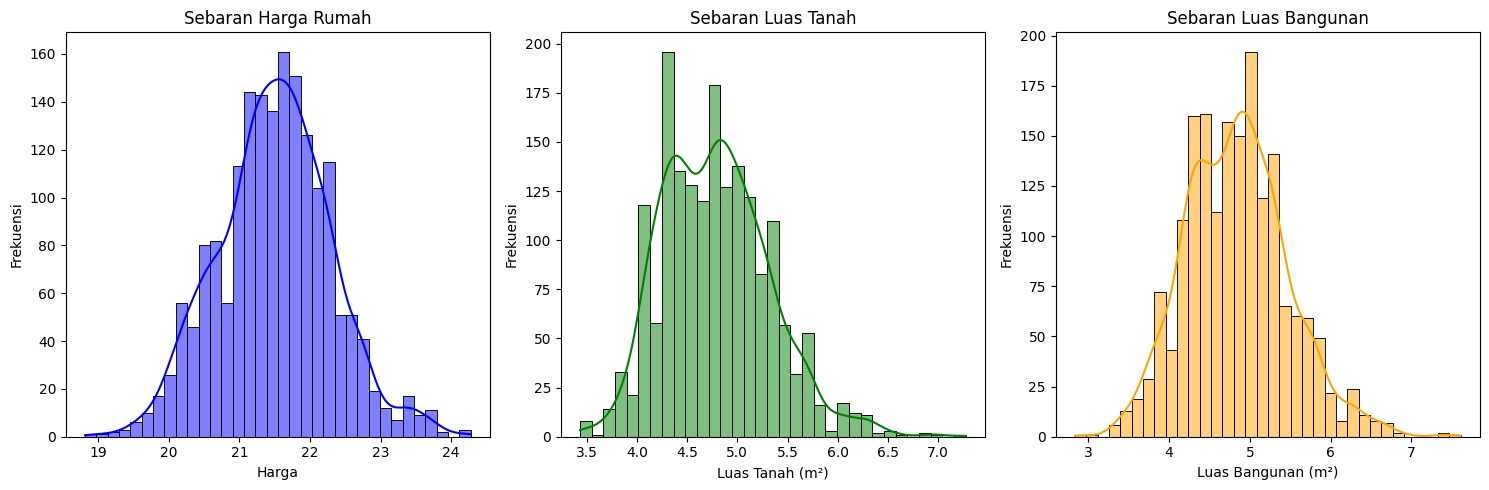

In [15]:
# Melakukan log transformation pada kolom 'Harga', 'Luas Tanah', dan 'Luas Bangunan'
df_kabupaten['Harga'] = np.log1p(df_kabupaten['Harga'])
df_kabupaten['Luas Tanah'] = np.log1p(df_kabupaten['Luas Tanah'])
df_kabupaten['Luas Bangunan'] = np.log1p(df_kabupaten['Luas Bangunan'])

# Menampilkan distribusi harga setelah transformasi
# Mengatur ukuran plot
plt.figure(figsize=(15, 5))

# Plot untuk harga
plt.subplot(1, 3, 1)  # 1 baris, 3 kolom, subplot ke-1
sns.histplot(df_kabupaten['Harga'], kde=True, color='blue')
plt.title('Sebaran Harga Rumah')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')

# Plot untuk luas tanah
plt.subplot(1, 3, 2)  # 1 baris, 3 kolom, subplot ke-2
sns.histplot(df_kabupaten['Luas Tanah'], kde=True, color='green')
plt.title('Sebaran Luas Tanah')
plt.xlabel('Luas Tanah (m²)')
plt.ylabel('Frekuensi')

# Plot untuk luas bangunan
plt.subplot(1, 3, 3)  # 1 baris, 3 kolom, subplot ke-3
sns.histplot(df_kabupaten['Luas Bangunan'], kde=True, color='orange')
plt.title('Sebaran Luas Bangunan')
plt.xlabel('Luas Bangunan (m²)')
plt.ylabel('Frekuensi')

# Menampilkan plot
plt.tight_layout()
plt.show()

#### Encoding

In [16]:
# Encoding Sertifikat
sertif_enc = OrdinalEncoder(categories=[
    ['PPJB', 'HGB', 'Lainnya', 'SHM']  # Urutan Sertifikat (PPJB rendah, SHM tertinggi)
])

df_kabupaten[['Sertifikat']] = sertif_enc.fit_transform(df_kabupaten[['Sertifikat']])

# Encoding Kondisi Properti
kondisi_enc = OrdinalEncoder(categories=[
    ['Butuh Renovasi', 'Bagus', 'Baru']  # Urutan Kondisi Properti
])

df_kabupaten[['Kondisi Properti']] = kondisi_enc.fit_transform(df_kabupaten[['Kondisi Properti']])

# Enncoding Daya Listrik
watt_enc = OrdinalEncoder(categories=[
    [450, 900, 1300, 2200, 3300, 3500, 4400, 5500, 6600, 7600, 7700, 8000, 10000, 10600, 11000, 13200, 16500, 22000, 23000, 30500, 33000] # Urutan daya listrik
])

df_kabupaten[['Daya Listrik']] = watt_enc.fit_transform(df_kabupaten[['Daya Listrik']])

# Encoding Kecamatan
df_kabupaten = pd.get_dummies(df_kabupaten, columns=['Kecamatan'], prefix='kec')

# Lihat hasilnya
df_kabupaten.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1802 entries, 6 to 4990
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Harga                 1802 non-null   float64
 1   Kamar Tidur           1802 non-null   Int64  
 2   Kamar Mandi           1802 non-null   Int64  
 3   Luas Tanah            1802 non-null   Float64
 4   Luas Bangunan         1802 non-null   Float64
 5   Sertifikat            1802 non-null   float64
 6   Daya Listrik          1802 non-null   float64
 7   Jumlah Lantai         1802 non-null   Int64  
 8   Kondisi Properti      1802 non-null   float64
 9   Carport               1802 non-null   Int64  
 10  Kamar Tidur Pembantu  1802 non-null   Int64  
 11  Kamar Mandi Pembantu  1802 non-null   Int64  
 12  kec_Balaraja          1802 non-null   bool   
 13  kec_Cikupa            1802 non-null   bool   
 14  kec_Cisauk            1802 non-null   bool   
 15  kec_Curug             1802

In [17]:
# Lihat 5 data teratas setelah encoding
df_kabupaten.head()

,Harga,Kamar Tidur,Kamar Mandi,Luas Tanah,Luas Bangunan,Sertifikat,Daya Listrik,Jumlah Lantai,Kondisi Properti,Carport,...,kec_Mauk,kec_Pagedangan,kec_Panongan,kec_Pasar Kemis,kec_Rajeg,kec_Sepatan,kec_Sindang Jaya,kec_Solear,kec_Teluk Naga,kec_Tigaraksa
6,20.723266,2,1,4.51086,4.025352,3.0,3.0,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
8,20.723266,2,1,4.51086,4.025352,3.0,3.0,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
14,20.723266,3,2,6.46925,4.912655,3.0,2.0,1,1.0,1,...,False,False,False,False,False,False,False,False,False,False
15,20.723266,3,2,4.204693,4.382027,3.0,5.0,2,1.0,1,...,False,False,False,True,False,False,False,False,False,False
21,20.723266,3,3,4.795791,5.117994,3.0,2.0,2,2.0,2,...,False,False,False,False,False,False,False,False,False,False


#### Feature Selection

<Axes: >

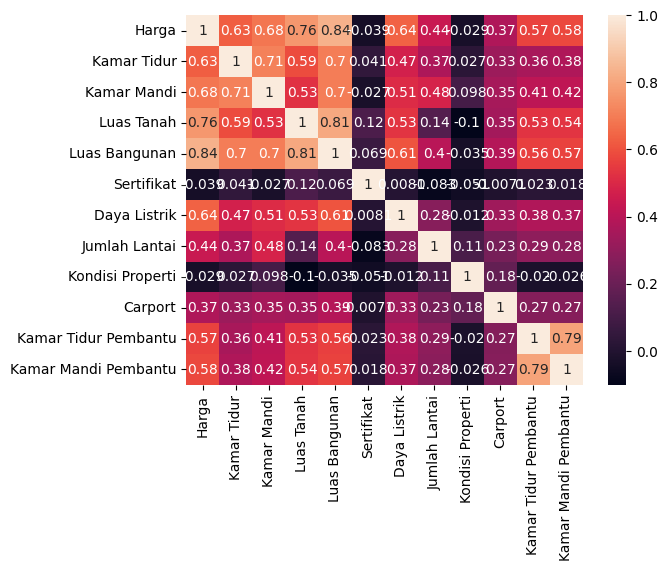

In [18]:
# Lihat korelasi antar variabel numerik (Pearson)
sns.heatmap(df_kabupaten.select_dtypes(include=['number']).corr(), annot=True)

#### Data Splitting
Drop kolom sertifikat dan kondisi properti karena nilai korelasi yang rendah (mendekati 0)

In [19]:
# Pisahkan fitur dan target
X = df_kabupaten.drop(columns=['Harga', 'Sertifikat', 'Kondisi Properti'], axis=1)
y = df_kabupaten['Harga']

# Split dataset menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling & Evaluation
---
Base Model Linear Regression

In [20]:
# Inisialisasi model Linear Regression
lr = LinearRegression()

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Definisikan metrik
rmse_scorer = make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred), greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Lakukan cross-validation
r2_scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='r2')
rmse_scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring=rmse_scorer)
mape_scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring=mape_scorer)

# Tampilkan hasil rata-rata cross-validation
print("Cross validation score on base Multiple Linear Regression:")
print(f"Mean CV R²: {np.mean(r2_scores):.4f}")
print(f"Mean CV RMSE: {np.abs(np.mean(rmse_scores)):.4f}")  # RMSE negatif diubah ke positif
print(f"Mean CV MAPE: {np.abs(np.mean(mape_scores)):.4f}")

# **Latih ulang model pada seluruh data pelatihan setelah cross-validation**
lr.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_lr_train = lr.predict(X_train)

# Menghitung metrik pada data uji
train_r2_base_lr = r2_score(y_train, y_pred_lr_train)
train_rmse_base_lr = root_mean_squared_error(y_train, y_pred_lr_train)
train_mape_base_lr = mean_absolute_percentage_error(y_train, y_pred_lr_train)

# Melakukan prediksi pada data uji
y_pred_lr = lr.predict(X_test)

# Menghitung metrik pada data uji
test_r2_base_lr = r2_score(y_test, y_pred_lr)
test_rmse_base_lr = root_mean_squared_error(y_test, y_pred_lr)
test_mape_base_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print("\nMultiple Linear Regression Result:")
print(f"Train R²: {train_r2_base_lr:.4f}")
print(f"Train RMSE: {train_rmse_base_lr:.4f}")
print(f"Train MAPE: {train_mape_base_lr:.4f}")
print(f"\nTest R²: {test_r2_base_lr:.4f}")
print(f"Test RMSE: {test_rmse_base_lr:.4f}")
print(f"Test MAPE: {test_mape_base_lr:.4f}")

Cross validation score on base Multiple Linear Regression:
Mean CV R²: 0.8690
Mean CV RMSE: 0.2877
Mean CV MAPE: 0.0102

Multiple Linear Regression Result:
Train R²: 0.8782
Train RMSE: 0.2785
Train MAPE: 0.0099

Test R²: 0.8844
Test RMSE: 0.2778
Test MAPE: 0.0098


Base Model Random Forest

In [21]:
# Inisialisasi model
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Melakukan cross-validation otomatis
r2_scores = cross_val_score(rfr, X_train, y_train, cv=kf, scoring="r2")
rmse_scores = np.sqrt(-cross_val_score(rfr, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"))
mape_scores = cross_val_score(rfr, X_train, y_train, cv=kf, scoring="neg_mean_absolute_percentage_error") * -1

# Menghitung rata-rata metrik dari cross-validation
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)

print("Cross-validation score on base Random Forest:")
print(f"Mean CV R²: {mean_r2:.4f}")
print(f"Mean CV RMSE: {mean_rmse:.4f}")
print(f"Mean CV MAPE: {mean_mape:.4f}")

# Melatih model pada seluruh data pelatihan
rfr.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_rf_train = rfr.predict(X_train)

# Menghitung metrik pada data latih
train_r2_base_rfr = r2_score(y_train, y_pred_rf_train)
train_rmse_base_rfr = root_mean_squared_error(y_train, y_pred_rf_train)
train_mape_base_rfr = mean_absolute_percentage_error(y_train, y_pred_rf_train)

# Melakukan prediksi pada data uji
y_pred_rf = rfr.predict(X_test)

# Menghitung metrik pada data uji
test_r2_base_rfr = r2_score(y_test, y_pred_rf)
test_rmse_base_rfr = root_mean_squared_error(y_test, y_pred_rf)
test_mape_base_rfr = mean_absolute_percentage_error(y_test, y_pred_rf)

print("\nBase Random Forest Result:")
print(f"Train R²: {train_r2_base_rfr:.4f}")
print(f"Train RMSE: {train_rmse_base_rfr:.4f}")
print(f"Train MAPE: {train_mape_base_rfr:.4f}\n")
print(f"Test R²: {test_r2_base_rfr:.4f}")
print(f"Test RMSE: {test_rmse_base_rfr:.4f}")
print(f"Test MAPE: {test_mape_base_rfr:.4f}")

Cross-validation score on base Random Forest:
Mean CV R²: 0.8944
Mean CV RMSE: 0.2581
Mean CV MAPE: 0.0083

Base Random Forest Result:
Train R²: 0.9853
Train RMSE: 0.0967
Train MAPE: 0.0031

Test R²: 0.9115
Test RMSE: 0.2431
Test MAPE: 0.0075


Base Model XGBoost

In [22]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# Fungsi untuk RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Inisialisasi model
xgb = XGBRegressor(verbosity=0, n_jobs=-1, random_state=42)

# Inisialisasi KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Melakukan cross-validation otomatis
r2_scores = cross_val_score(xgb, X_train, y_train, cv=kf, scoring="r2")
rmse_scores = np.sqrt(-cross_val_score(xgb, X_train, y_train, cv=kf, scoring="neg_mean_squared_error"))
mape_scores = cross_val_score(xgb, X_train, y_train, cv=kf, scoring="neg_mean_absolute_percentage_error") * -1

# Menghitung rata-rata metrik dari cross-validation
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)
mean_mape = np.mean(mape_scores)

print("Cross-validation score on base XGBoost:")
print(f"Mean CV R²: {mean_r2:.4f}")
print(f"Mean CV RMSE: {mean_rmse:.4f}")
print(f"Mean CV MAPE: {mean_mape:.4f}")

# Melatih model pada seluruh data pelatihan
xgb.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_xgb_train = xgb.predict(X_train)

# Menghitung metrik pada data latih
train_r2_base_xgb = r2_score(y_train, y_pred_xgb_train)
train_rmse_base_xgb = root_mean_squared_error(y_train, y_pred_xgb_train)
train_mape_base_xgb = mean_absolute_percentage_error(y_train, y_pred_xgb_train)

# Melakukan prediksi pada data uji
y_pred_xgb = xgb.predict(X_test)

# Menghitung metrik pada data uji
test_r2_base_xgb = r2_score(y_test, y_pred_xgb)
test_rmse_base_xgb = root_mean_squared_error(y_test, y_pred_xgb)
test_mape_base_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("\nBase XGBoost Result:")
print(f"Train R²: {train_r2_base_xgb:.4f}")
print(f"Train RMSE: {train_rmse_base_xgb:.4f}")
print(f"Train MAPE: {train_mape_base_xgb:.4f}\n")
print(f"Test R²: {test_r2_base_xgb:.4f}")
print(f"Test RMSE: {test_rmse_base_xgb:.4f}")
print(f"Test MAPE: {test_mape_base_xgb:.4f}")

Cross-validation score on base XGBoost:
Mean CV R²: 0.8976
Mean CV RMSE: 0.2537
Mean CV MAPE: 0.0084

Base XGBoost Result:
Train R²: 0.9909
Train RMSE: 0.0759
Train MAPE: 0.0025

Test R²: 0.9171
Test RMSE: 0.2353
Test MAPE: 0.0072


Random Forest dengan Optuna

In [23]:
# Fungsi Optuna untuk tuning Random Forest
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1200, 2000, step=100),
        "max_depth": trial.suggest_int("max_depth", 20, 50, step=5),
        "min_samples_split": trial.suggest_int("min_samples_split", 4, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_float("max_features", 0.4, 0.7),
        "bootstrap": True,
        "max_samples": trial.suggest_float("max_samples", 0.8, 0.95),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.005),
        "warm_start": True,
        "oob_score": True
    }

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)

    # Gunakan 5-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2", n_jobs=-1)

    return np.mean(scores)  # Ambil rata-rata R² sebagai metric utama

# Jalankan Optuna
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective, n_trials=100)

# Print hasil tuning terbaik
print("Best hyperparameters for Random Forest:", study_rf.best_params)

# Latih model final dengan hyperparameter terbaik
best_params_rf = study_rf.best_params
final_rf = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
final_rf.fit(X_train, y_train)

# Evaluasi model di data latih
y_pred_opt_rf_train = final_rf.predict(X_train)
train_rmse_opt_rfr = root_mean_squared_error(y_train, y_pred_opt_rf_train)
train_r2_opt_rfr = r2_score(y_train, y_pred_opt_rf_train)
train_mape_opt_rfr = mean_absolute_percentage_error(y_train, y_pred_opt_rf_train)

# Evaluasi model di data uji
y_pred_opt_rf = final_rf.predict(X_test)
test_rmse_opt_rfr = root_mean_squared_error(y_test, y_pred_opt_rf)
test_r2_opt_rfr = r2_score(y_test, y_pred_opt_rf)
test_mape_opt_rfr = mean_absolute_percentage_error(y_test, y_pred_opt_rf)

print("\nRandom Forest Optuna Result:")
print(f"Train R²: {train_r2_opt_rfr:.4f}")
print(f"Train RMSE: {train_rmse_opt_rfr:.4f}")
print(f"Train MAPE: {train_mape_opt_rfr:.4f}\n")
print(f"Test R²: {test_r2_opt_rfr:.4f}")
print(f"Test RMSE: {test_rmse_opt_rfr:.4f}")
print(f"Test MAPE: {test_mape_opt_rfr:.4f}")

[I 2025-03-17 09:31:54,461] A new study created in memory with name: no-name-75b3e055-2f13-4714-8989-4c46e948eec4
[I 2025-03-17 09:32:01,585] Trial 0 finished with value: 0.8846446382181016 and parameters: {'n_estimators': 1500, 'max_depth': 20, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 0.5842163317663942, 'max_samples': 0.8631147321205931, 'ccp_alpha': 0.0004010205926184346}. Best is trial 0 with value: 0.8846446382181016.
[I 2025-03-17 09:32:08,151] Trial 1 finished with value: 0.8578788961953302 and parameters: {'n_estimators': 1600, 'max_depth': 20, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.4080926908051672, 'max_samples': 0.8243111965345573, 'ccp_alpha': 0.0027939657403289043}. Best is trial 0 with value: 0.8846446382181016.
[I 2025-03-17 09:32:14,513] Trial 2 finished with value: 0.8537469786193684 and parameters: {'n_estimators': 1500, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 0.6058238930661655,

Best hyperparameters for Random Forest: {'n_estimators': 1300, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.6478995854246118, 'max_samples': 0.8324019704717578, 'ccp_alpha': 1.0959347626221484e-05}

Random Forest Optuna Result:
Train R²: 0.9757
Train RMSE: 0.1243
Train MAPE: 0.0042

Test R²: 0.9144
Test RMSE: 0.2392
Test MAPE: 0.0075


XGBoost dengan Optuna

In [24]:
# Definisikan fungsi tujuan untuk Optuna
def objective(trial):
    # Hyperparameter yang akan dioptimalkan
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1200, 2500, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03, log=True),
        "max_depth": trial.suggest_int("max_depth", 4, 7),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 6),
        "subsample": trial.suggest_float("subsample", 0.85, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.75, 0.95),
        "gamma": trial.suggest_float("gamma", 0.1, 3),
        "reg_alpha": trial.suggest_float("reg_alpha", 1, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1, 5)
    }

    # Inisialisasi model XGBoost
    model = XGBRegressor(**params, random_state=42, n_jobs=-1)

    # Evaluasi dengan cross_val_score menggunakan 5-Fold CV
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2", n_jobs=-1)

    return np.mean(scores)  # Mengembalikan rata-rata R² sebagai nilai yang akan dioptimalkan

# Tuning hyperparameter dengan Optuna
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=100)

# Menampilkan hyperparameter terbaik
print("Best hyperparameters: ", study_xgb.best_params)

# Melatih model dengan hyperparameter terbaik
best_params = study_xgb.best_params
best_model_xgb = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
best_model_xgb.fit(X_train, y_train)

# Melakukan prediksi pada data latih
y_pred_opt_xgb_train = best_model_xgb.predict(X_train)

# Menghitung metrik pada data latih
train_r2_opt_xgb = r2_score(y_train, y_pred_opt_xgb_train)
train_rmse_opt_xgb = root_mean_squared_error(y_train, y_pred_opt_xgb_train)
train_mape_opt_xgb = mean_absolute_percentage_error(y_train, y_pred_opt_xgb_train)

# Melakukan prediksi pada data uji
y_pred_opt_xgb = best_model_xgb.predict(X_test)

# Menghitung metrik pada data uji
test_r2_opt_xgb = r2_score(y_test, y_pred_opt_xgb)
test_rmse_opt_xgb = root_mean_squared_error(y_test, y_pred_opt_xgb)
test_mape_opt_xgb = mean_absolute_percentage_error(y_test, y_pred_opt_xgb)

print("\nXGBoost Optuna Result:")
print(f"Train R²: {train_r2_opt_xgb:.4f}")
print(f"Train RMSE: {train_rmse_opt_xgb:.4f}")
print(f"Train MAPE: {train_mape_opt_xgb:.4f}\n")
print(f"Test R²: {test_r2_opt_xgb:.4f}")
print(f"Test RMSE: {test_rmse_opt_xgb:.4f}")
print(f"Test MAPE: {test_mape_opt_xgb:.4f}")

[I 2025-03-17 09:39:34,196] A new study created in memory with name: no-name-cab5c6f7-4ef9-4757-a20b-57b4b28b3f76
[I 2025-03-17 09:39:34,834] Trial 0 finished with value: 0.8611899518550097 and parameters: {'n_estimators': 1900, 'learning_rate': 0.020017447440166074, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8886304865755142, 'colsample_bytree': 0.8314149837643604, 'gamma': 2.2318239404174736, 'reg_alpha': 4.172747175099107, 'reg_lambda': 2.5482162658651495}. Best is trial 0 with value: 0.8611899518550097.
[I 2025-03-17 09:39:35,352] Trial 1 finished with value: 0.8726672437508973 and parameters: {'n_estimators': 1400, 'learning_rate': 0.02337996140560981, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8874456669246361, 'colsample_bytree': 0.9062245960282598, 'gamma': 1.9915050598060975, 'reg_alpha': 1.188263500596797, 'reg_lambda': 3.00914974739145}. Best is trial 1 with value: 0.8726672437508973.
[I 2025-03-17 09:39:36,179] Trial 2 finished with value: 0.8870936818

Best hyperparameters:  {'n_estimators': 1700, 'learning_rate': 0.010841545669403133, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9392013965325448, 'colsample_bytree': 0.7515794940600125, 'gamma': 0.10258442006998802, 'reg_alpha': 1.0288093845368789, 'reg_lambda': 1.3148864750496736}

XGBoost Optuna Result:
Train R²: 0.9367
Train RMSE: 0.2008
Train MAPE: 0.0071

Test R²: 0.9096
Test RMSE: 0.2457
Test MAPE: 0.0082


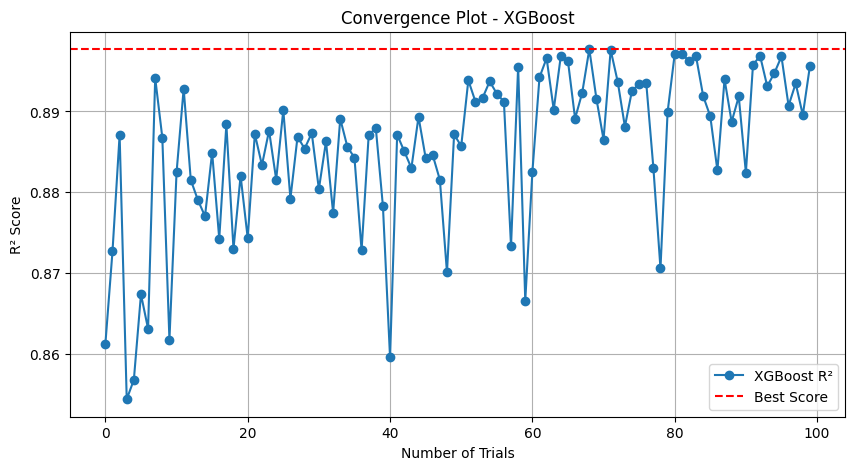

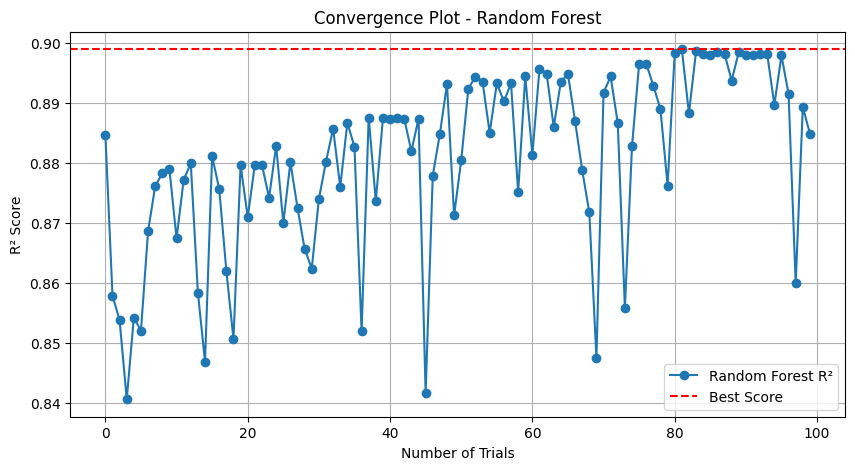

In [25]:
# Fungsi untuk menampilkan convergence plot
def plot_convergence(study, model_name):
    trials = study.trials_dataframe()
    
    plt.figure(figsize=(10, 5))
    plt.plot(trials["number"], trials["value"], marker="o", linestyle="-", label=f"{model_name} R²")
    plt.axhline(y=max(trials["value"]), color="r", linestyle="--", label="Best Score")
    
    plt.xlabel("Number of Trials")
    plt.ylabel("R² Score")
    plt.title(f"Convergence Plot - {model_name}")
    plt.legend()
    plt.grid()
    plt.show()

# Menampilkan plot untuk XGBoost dan Random Forest
plot_convergence(study_xgb, "XGBoost")
plot_convergence(study_rf, "Random Forest")

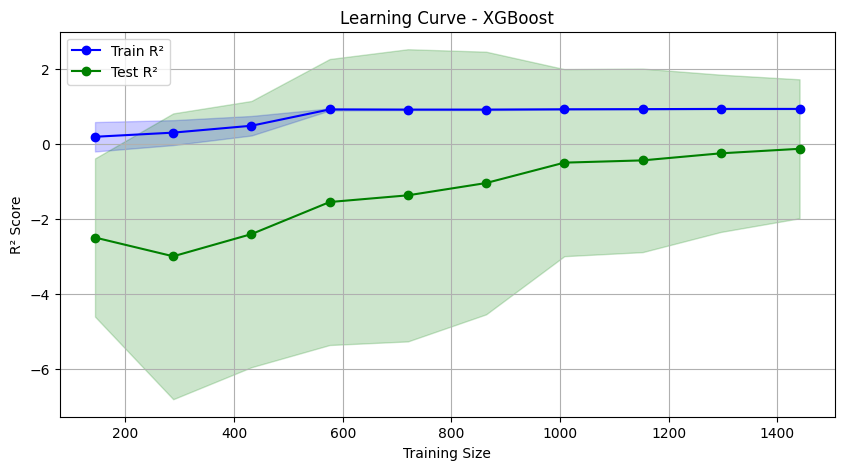

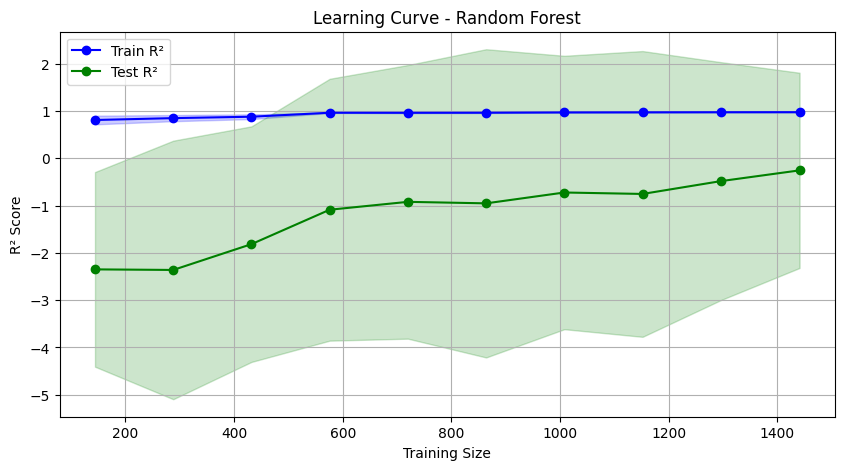

In [26]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, model_name):
    """Plot Learning Curve (Train vs Test)"""
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="r2", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_sizes, train_mean, label="Train R²", marker="o", color="blue")
    plt.plot(train_sizes, test_mean, label="Test R²", marker="o", color="green")
    
    plt.fill_between(train_sizes, train_mean - np.std(train_scores, axis=1), 
                     train_mean + np.std(train_scores, axis=1), color="blue", alpha=0.2)
    plt.fill_between(train_sizes, test_mean - np.std(test_scores, axis=1), 
                     test_mean + np.std(test_scores, axis=1), color="green", alpha=0.2)
    
    plt.xlabel("Training Size")
    plt.ylabel("R² Score")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend()
    plt.grid()
    plt.show()

# Gunakan model terbaik dari Optuna
best_xgb = XGBRegressor(**study_xgb.best_params, random_state=42)
best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)

# Plot Learning Curve
plot_learning_curve(best_xgb, X, y, "XGBoost")
plot_learning_curve(best_rf, X, y, "Random Forest")


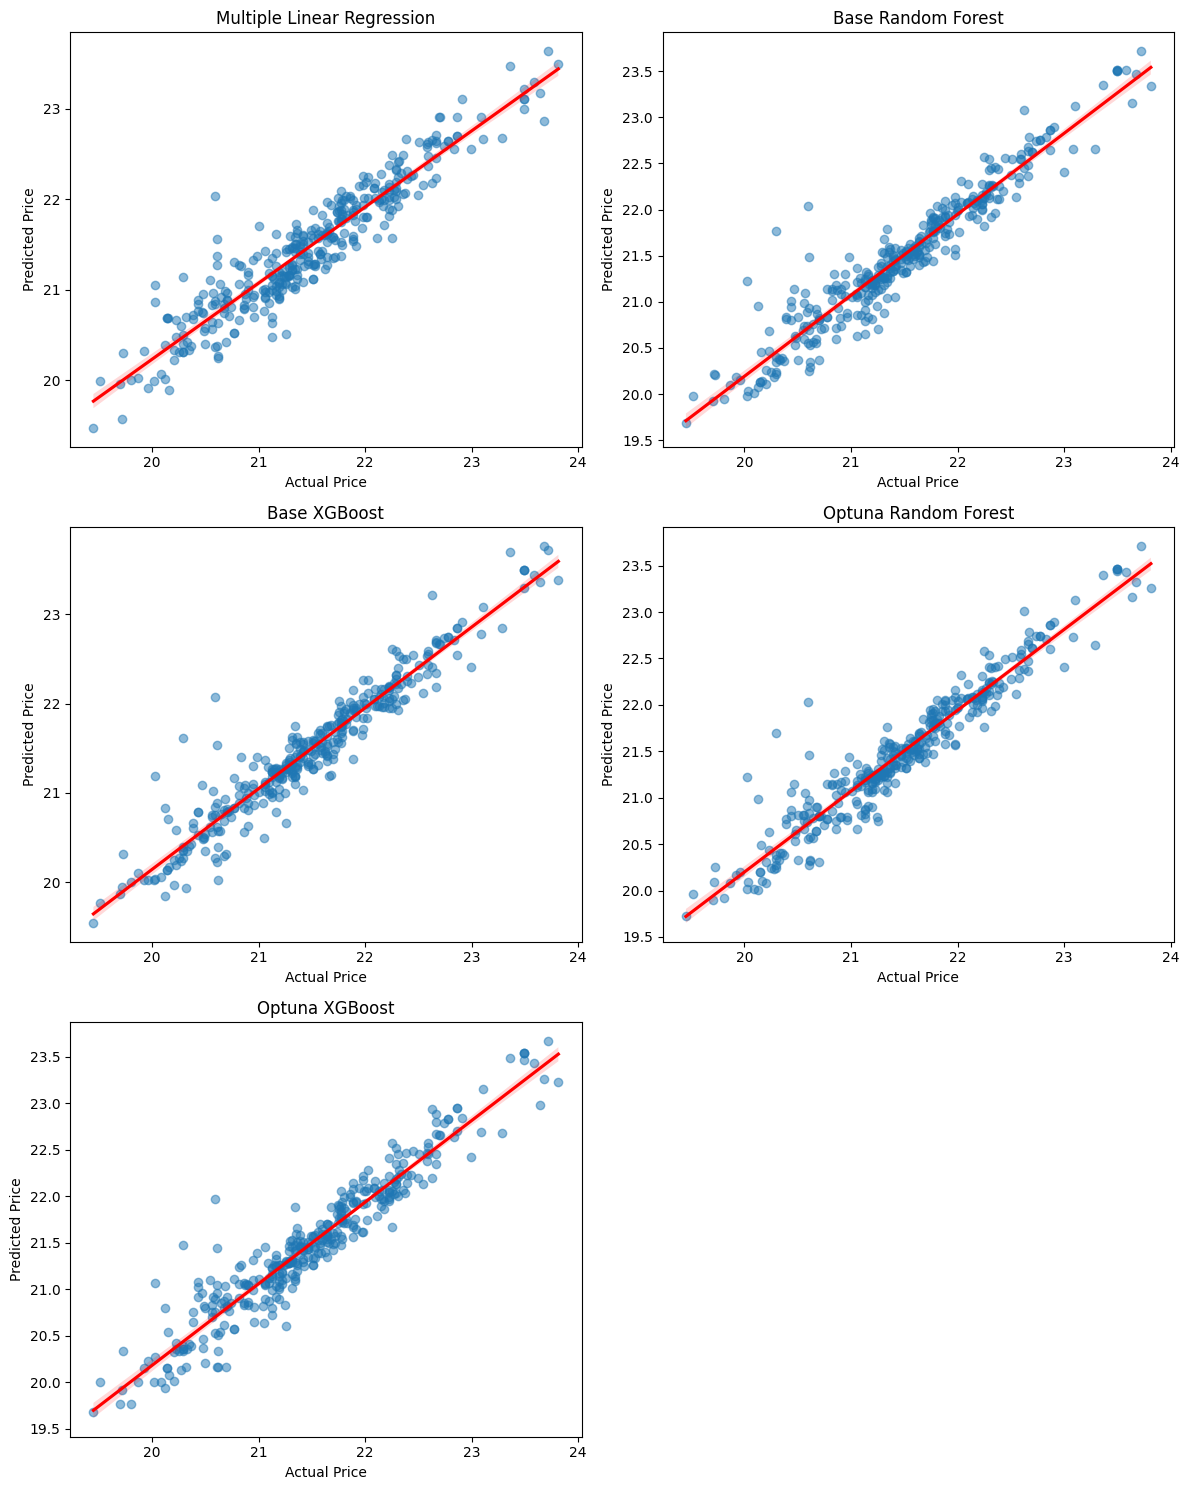

In [27]:
# Buat figure dan axis untuk 3x2 grid (karena ada 5 model, satu slot akan kosong)
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Plot untuk Multiple Linear Regression
sns.regplot(x=y_test, y=y_pred_lr, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[0, 0])
axes[0, 0].set_title('Multiple Linear Regression')
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')

# Plot untuk Base Random Forest
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[0, 1])
axes[0, 1].set_title('Base Random Forest')
axes[0, 1].set_xlabel('Actual Price')
axes[0, 1].set_ylabel('Predicted Price')

# Plot untuk Base XGBoost
sns.regplot(x=y_test, y=y_pred_xgb, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[1, 0])
axes[1, 0].set_title('Base XGBoost')
axes[1, 0].set_xlabel('Actual Price')
axes[1, 0].set_ylabel('Predicted Price')

# Plot untuk Optuna Random Forest
sns.regplot(x=y_test, y=y_pred_opt_rf, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[1, 1])
axes[1, 1].set_title('Optuna Random Forest')
axes[1, 1].set_xlabel('Actual Price')
axes[1, 1].set_ylabel('Predicted Price')

# Plot untuk Optuna XGBoost
sns.regplot(x=y_test, y=y_pred_opt_xgb, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}, ax=axes[2, 0])
axes[2, 0].set_title('Optuna XGBoost')
axes[2, 0].set_xlabel('Actual Price')
axes[2, 0].set_ylabel('Predicted Price')

# Hapus subplot kosong (axes[2,1])
fig.delaxes(axes[2, 1])

# Atur layout agar tidak bertabrakan
plt.tight_layout()
plt.show()

In [28]:
# Bandingkan nilai prediksi dengan nilai sebenarnya
# Inverse nilai log transformation ke nilai sebenarnya
y_test_actual = np.expm1(y_test)
y_pred_lr_actual = np.expm1(y_pred_lr)
y_pred_rf_actual = np.expm1(y_pred_rf)
y_pred_xgb_actual = np.expm1(y_pred_xgb)
y_pred_opt_rf_actual = np.expm1(y_pred_opt_rf)
y_pred_opt_xgb_actual = np.expm1(y_pred_opt_xgb)

# Buat DataFrame untuk setiap model
df_selisih_lr = pd.DataFrame({
    'Actual': y_test_actual[0:5],
    'Predicted': y_pred_lr_actual[0:5]
})
df_selisih_lr['Difference'] = df_selisih_lr['Predicted'] - df_selisih_lr['Actual']

df_selisih_rf = pd.DataFrame({
    'Actual': y_test_actual[0:5],
    'Predicted': y_pred_rf_actual[0:5]
})
df_selisih_rf['Difference'] = df_selisih_rf['Predicted'] - df_selisih_rf['Actual']

df_selisih_xgb = pd.DataFrame({
    'Actual': y_test_actual[0:5],
    'Predicted': y_pred_xgb_actual[0:5]
})
df_selisih_xgb['Difference'] = df_selisih_xgb['Predicted'] - df_selisih_xgb['Actual']

df_selisih_opt_rf = pd.DataFrame({
    'Actual': y_test_actual[0:5],
    'Predicted': y_pred_opt_rf_actual[0:5]
})
df_selisih_opt_rf['Difference'] = df_selisih_opt_rf['Predicted'] - df_selisih_opt_rf['Actual']

df_selisih_opt_xgb = pd.DataFrame({
    'Actual': y_test_actual[0:5],
    'Predicted': y_pred_opt_xgb_actual[0:5]
})
df_selisih_opt_xgb['Difference'] = df_selisih_opt_xgb['Predicted'] - df_selisih_opt_xgb['Actual']

# Menampilkan semua DataFrame
df_selisih_lr, df_selisih_rf, df_selisih_xgb, df_selisih_opt_rf, df_selisih_opt_xgb

(            Actual     Predicted    Difference
 4960  9.750000e+08  7.414356e+08 -2.335644e+08
 911   1.650000e+09  1.542365e+09 -1.076354e+08
 2865  3.300000e+09  2.143275e+09 -1.156725e+09
 496   1.380000e+09  1.319990e+09 -6.001007e+07
 3488  4.500000e+09  4.106641e+09 -3.933585e+08,
             Actual     Predicted    Difference
 4960  9.750000e+08  7.010780e+08 -2.739220e+08
 911   1.650000e+09  1.472576e+09 -1.774236e+08
 2865  3.300000e+09  2.754326e+09 -5.456738e+08
 496   1.380000e+09  1.436727e+09  5.672746e+07
 3488  4.500000e+09  3.816581e+09 -6.834195e+08,
             Actual     Predicted    Difference
 4960  9.750000e+08  6.619783e+08 -3.130217e+08
 911   1.650000e+09  1.557514e+09 -9.248563e+07
 2865  3.300000e+09  3.096022e+09 -2.039777e+08
 496   1.380000e+09  1.174405e+09 -2.055950e+08
 3488  4.500000e+09  3.818464e+09 -6.815357e+08,
             Actual     Predicted    Difference
 4960  9.750000e+08  6.588986e+08 -3.161014e+08
 911   1.650000e+09  1.455351e+09 -1.

Evaluasi Keseluruhan

In [29]:
df_eval_test = pd.DataFrame(data={
    'Model' : ['Multiple Linear Regression', 'Base Random Forest', 'Base XGBoost', 'Optuna Random Forest', 'Optuna XGBoost'],
    'R-squared' : [test_r2_base_lr, test_r2_base_rfr, test_r2_base_xgb, test_r2_opt_rfr, test_r2_opt_xgb],
    'RMSE' : [test_rmse_base_lr, test_rmse_base_rfr, test_rmse_base_xgb, test_rmse_opt_rfr, test_rmse_opt_xgb],
    'MAPE' : [test_mape_base_lr, test_mape_base_rfr, test_mape_base_xgb, test_mape_opt_rfr, test_mape_opt_xgb]
})

df_eval_train = pd.DataFrame(data={
    'Model' : ['Multiple Linear Regression', 'Base Random Forest', 'Base XGBoost', 'Optuna Random Forest', 'Optuna XGBoost'],
    'R-squared' : [train_r2_base_lr, train_r2_base_rfr, train_r2_base_xgb, train_r2_opt_rfr, train_r2_opt_xgb],
    'RMSE' : [train_rmse_base_lr, train_rmse_base_rfr, train_rmse_base_xgb, train_rmse_opt_rfr, train_rmse_opt_xgb],
    'MAPE' : [train_mape_base_lr, train_mape_base_rfr, train_mape_base_xgb, train_mape_opt_rfr, train_mape_opt_xgb]
})

for column in ['R-squared', 'RMSE', 'MAPE']:
    df_eval_test[column] = df_eval_test[column].map(lambda x: f"{x:.4f}")
    df_eval_train[column] = df_eval_train[column].map(lambda x: f"{x:.4f}")

print("Perbandingan akurasi di train set:\n")
df_eval_train

Perbandingan akurasi di train set:



,Model,R-squared,RMSE,MAPE
0,Multiple Linear Regression,0.8782,0.2785,0.0099
1,Base Random Forest,0.9853,0.0967,0.0031
2,Base XGBoost,0.9909,0.0759,0.0025
3,Optuna Random Forest,0.9757,0.1243,0.0042
4,Optuna XGBoost,0.9367,0.2008,0.0071


In [30]:
print("Perbandingan akurasi di test set:\n")
df_eval_test

Perbandingan akurasi di test set:



,Model,R-squared,RMSE,MAPE
0,Multiple Linear Regression,0.8844,0.2778,0.0098
1,Base Random Forest,0.9115,0.2431,0.0075
2,Base XGBoost,0.9171,0.2353,0.0072
3,Optuna Random Forest,0.9144,0.2392,0.0075
4,Optuna XGBoost,0.9096,0.2457,0.0082


In [31]:
import pkgutil
import importlib
import sys
import subprocess

# Mendapatkan daftar library yang diimport dalam notebook
imported_modules = {name for _, name, _ in pkgutil.iter_modules() if importlib.util.find_spec(name)}

# Mengambil daftar package yang terinstal beserta versinya
from importlib.metadata import distributions  # Untuk Python 3.8+
installed_packages = {dist.metadata["Name"].lower(): dist.metadata["Version"] for dist in distributions()}

# Menyaring hanya library yang diimpor dalam notebook
used_packages = {pkg: installed_packages[pkg] for pkg in imported_modules if pkg in installed_packages}

# Simpan ke file requirements.txt
with open("notebook_requirements.txt", "w") as f:
    for pkg, version in used_packages.items():
        f.write(f"{pkg}=={version}\n")

print("requirements.txt telah dibuat.")

requirements.txt telah dibuat.


In [32]:
# Export model untuk persiapan deployment
import pickle

# Simpan model XGBoost Optuna
with open("../Model/xgboost_optuna.pkl", "wb") as f:
    pickle.dump(best_model_xgb, f)

# Simpan Ordinal Encoder Daya Listrik
with open("../Model/encoder_data_listrik.pkl", "wb") as f:
    pickle.dump(watt_enc, f)

print("Semua objek telah disimpan dalam file .pkl!")

Semua objek telah disimpan dalam file .pkl!
